# Lab 3: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by October 17, 2018. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques but hdbscan
import scipy
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

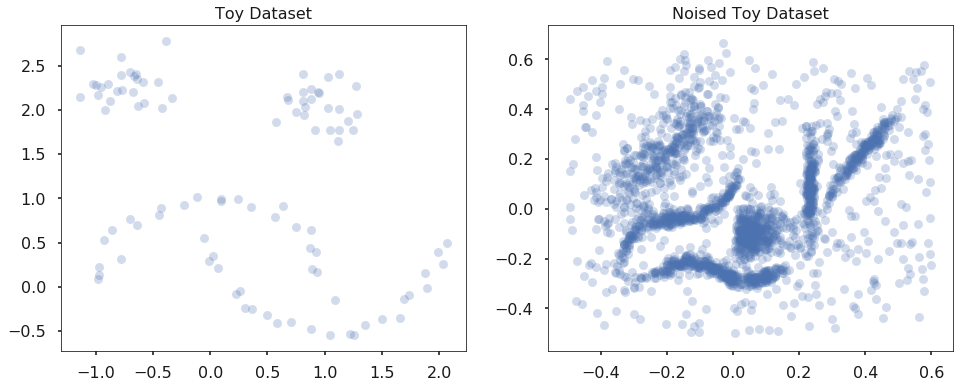

In [4]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

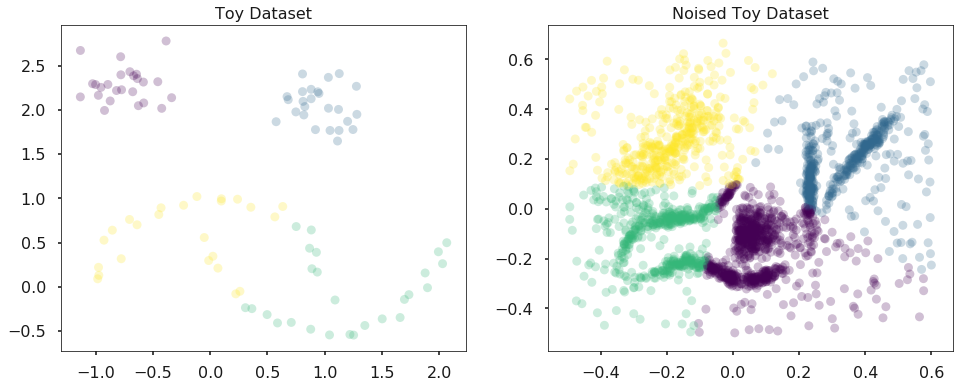

In [5]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [34]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def distance(self, x1, x2):
        if self.metric_ == "euclidean":
            diff = x1-x2
            dist = (diff).T @ (diff)
            return(dist)
        
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        
        #Initialization of variables
        num_samples, num_features =  X.shape
        
        DC=np.zeros((num_samples, num_samples))
        linkage_matrix = np.zeros((num_samples-1,4))
        hierarchy = [np.array(list(range(num_samples)))]
        
        clust = [] #Follows cluster positions 
        for i in range(num_samples):
            clust.append([i])
        
        #Putting distances in DC
        for i in range(num_samples-1):
            for k in range(i+1,num_samples):
                dist=self.distance(X[i,:],X[k,:])
                DC[i,k]=dist
                DC[k,i]=dist
                
        #DC diag is set to maximum of DC + 1 to avoid any issue with the min search
        max_DC = np.max(DC) + 1
        DC = DC + (max_DC) * np.identity(DC.shape[0])
                
        
        for i in range(num_samples-1):
            #Min lookup
            i1, i2 = DC.argmin()//DC.shape[0], DC.argmin()%DC.shape[1]
            
            #Sorting the two indexes
            min1 = min(i1,i2)
            min2 = max(i1,i2)
            dist = DC[min1,min2]
            
            X1 = DC[:,i1] #Colonne 1
            X2 = DC[:,i2] #Colonne 2
            
            #Column to add to DC (and putting maximum of DC + 1 in the diag)
            newcol = np.ones(DC.shape[0]-1) * max_DC 
            
            c=0 
            for j in range(DC.shape[0]):
                if j!= i1 and j!= i2:
                    m = min(X1[j], X2[j])
                    newcol[c]=m
                    c+=1
                    
            #Deleting old columns, starting with the one with the bigger index
            DC = np.delete(DC, i2, 0)
            DC = np.delete(DC, i2, 1)
            DC = np.delete(DC, i1, 0)
            DC = np.delete(DC, i1, 1)
            
            #Deleting zero at the end to concatenate
            newcol2 = np.delete(newcol, newcol.shape[0]-1, 0)
            
            newcol = newcol.reshape(newcol.shape[0],1)
            newcol2 = newcol2.reshape(1, newcol2.shape[0])
            
            DC = np.concatenate((DC, newcol2), 0)
            DC = np.concatenate((DC, newcol), 1)
            
            size_cluster_min1 = len(clust[min1])
            size_cluster_min2 = len(clust[min2])
            
            size = size_cluster_min1 + size_cluster_min2 
            
            linkage_matrix[i, 0] = hierarchy[i][clust[min1][0] ]
            linkage_matrix[i, 1] = hierarchy[i][clust[min2][0]]
            linkage_matrix[i, 2] = dist
            linkage_matrix[i, 3] = size
            
            #Updating clust
            new_cluster = clust[min1] + clust[min2]
            clust.append(new_cluster)
            del clust[min2]
            del clust[min1]
            
            #Updating hierarchy
            hierarchy_new = np.copy(hierarchy[i])
            for j in new_cluster:
                hierarchy_new[j] = num_samples + i
            hierarchy.append(hierarchy_new)
            
            n_clusters = self.n_clusters_
        
        l=0 #labels
        labels = [0]*num_samples
        distinct = list(set(hierarchy[-n_clusters]))
        for k in distinct :
            for j in range(hierarchy[-n_clusters].shape[0]):
                if hierarchy[-n_clusters][j] == k:
                    labels[j] = l
            l+=1
        
        self.labels_ = np.array(labels)    
        self.linkage_matrix_ = linkage_matrix
        self.hierarchy_ = hierarchy
        
        
        
    def plot_dendrogram(self, X):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''  
        Z = self.linkage_matrix_
        scipy.cluster.hierarchy.dendrogram(Z)
        plt.show()
        

In [35]:
model = my_SingleLinkageAglomerativeClustering()
model.fit(test_data_0)

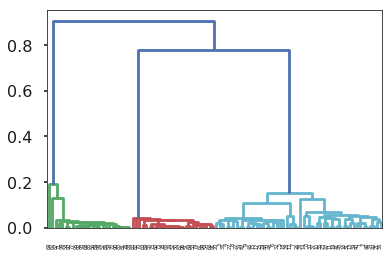

In [36]:
model.plot_dendrogram(test_data_0)

In [37]:
model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1])

Try the different linkage methods implemented in `sklearn`  and comment

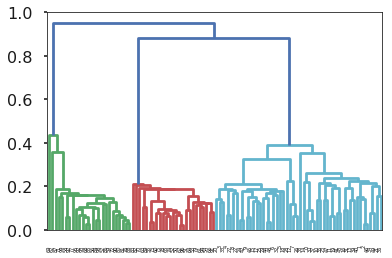

In [10]:
#Single linkage
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram

Z = scipy.cluster.hierarchy.linkage(test_data_0, 'single')

dn = scipy.cluster.hierarchy.dendrogram(Z)

plt.show()

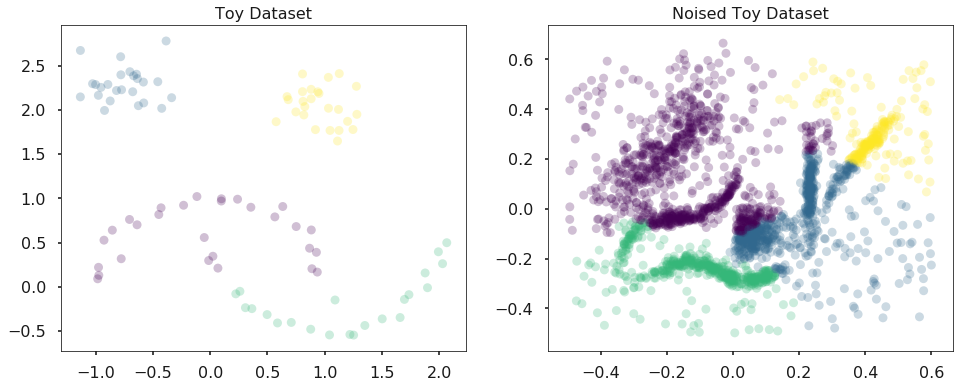

In [11]:
# Complete linkage 
complete_link_0 = cluster.AgglomerativeClustering(linkage ='complete', n_clusters=4).fit(test_data_0)
complete_link_1 = cluster.AgglomerativeClustering(linkage ='complete', n_clusters=4).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=complete_link_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=complete_link_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

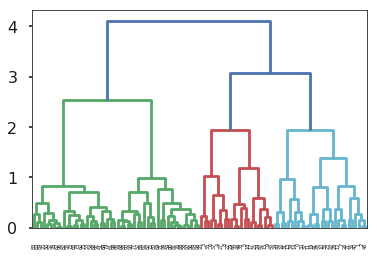

In [12]:
Z1 = scipy.cluster.hierarchy.linkage(test_data_0, 'complete')

dn1 = scipy.cluster.hierarchy.dendrogram(Z1)

plt.show()

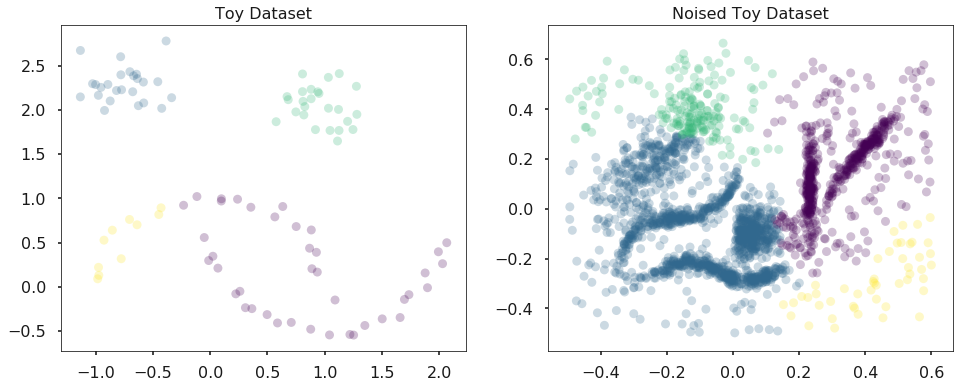

In [13]:
# Average linkage 
average_link_0 = cluster.AgglomerativeClustering(linkage ='average', n_clusters=4).fit(test_data_0)
average_link_1 = cluster.AgglomerativeClustering(linkage ='average', n_clusters=4).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=average_link_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=average_link_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

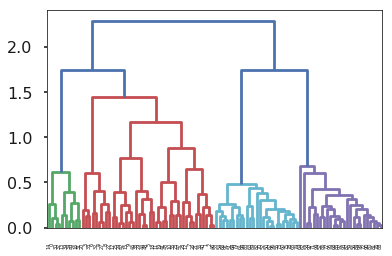

In [14]:
Z2 = scipy.cluster.hierarchy.linkage(test_data_0, 'average')

dn2 = scipy.cluster.hierarchy.dendrogram(Z2)

plt.show()

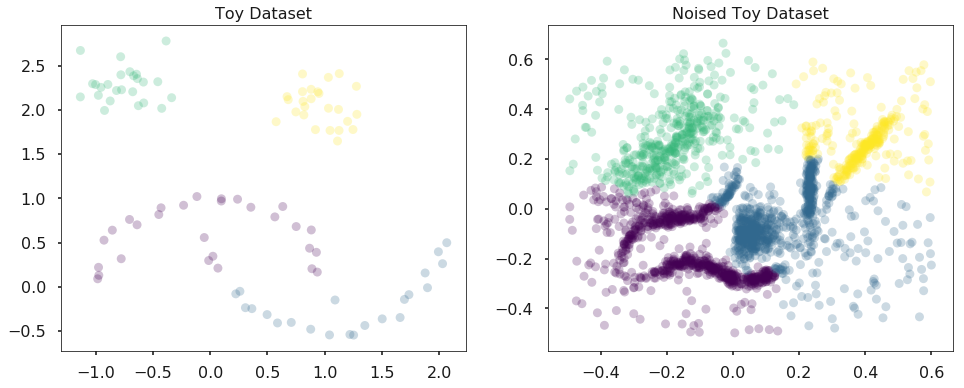

In [15]:
# Objective linkage (Ward)
ward_link_0 = cluster.AgglomerativeClustering(linkage ='ward', n_clusters=4).fit(test_data_0)
ward_link_1 = cluster.AgglomerativeClustering(linkage ='ward', n_clusters=4).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=ward_link_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=ward_link_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

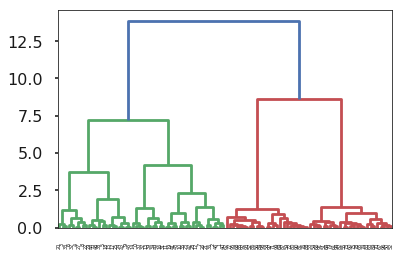

In [16]:
Z3 = scipy.cluster.hierarchy.linkage(test_data_0, 'ward')

dn3 = scipy.cluster.hierarchy.dendrogram(Z3)

plt.show()


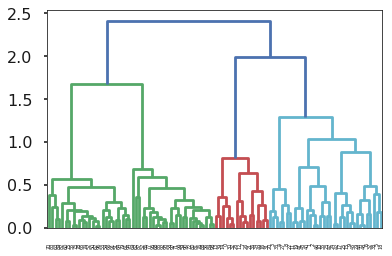

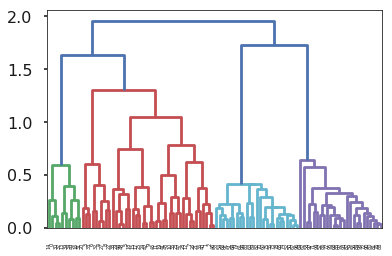

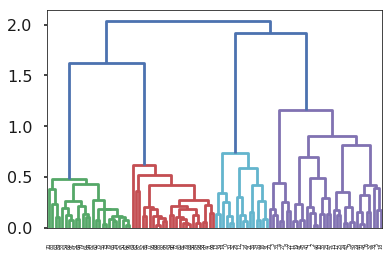

In [17]:

Z4 = scipy.cluster.hierarchy.linkage(test_data_0, 'weighted')

dn4 = scipy.cluster.hierarchy.dendrogram(Z4)

plt.show()

Z5 = scipy.cluster.hierarchy.linkage(test_data_0, 'centroid')

dn5 = scipy.cluster.hierarchy.dendrogram(Z5)

plt.show()

Z6 = scipy.cluster.hierarchy.linkage(test_data_0, 'median')

dn6 = scipy.cluster.hierarchy.dendrogram(Z6)

plt.show()


## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

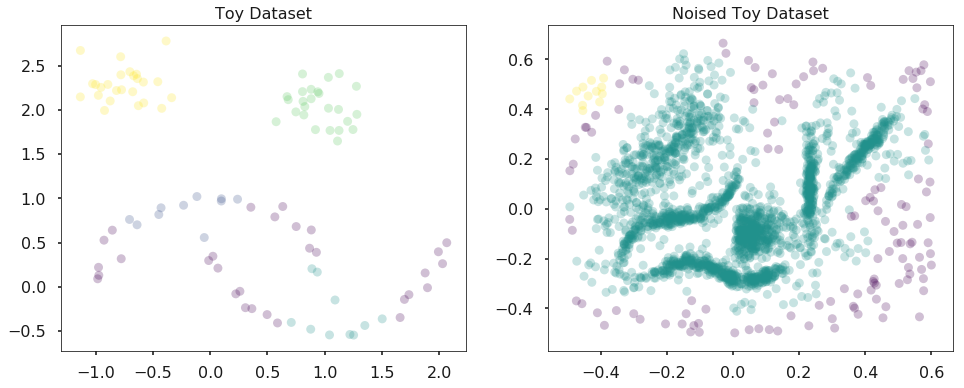

In [18]:
# DBSCAN
dbscan_0 = cluster.DBSCAN(algorithm='auto', eps=0.5, leaf_size=20, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None).fit(test_data_0)
dbscan_1 = cluster.DBSCAN(algorithm='auto', eps=0.07, leaf_size=20, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

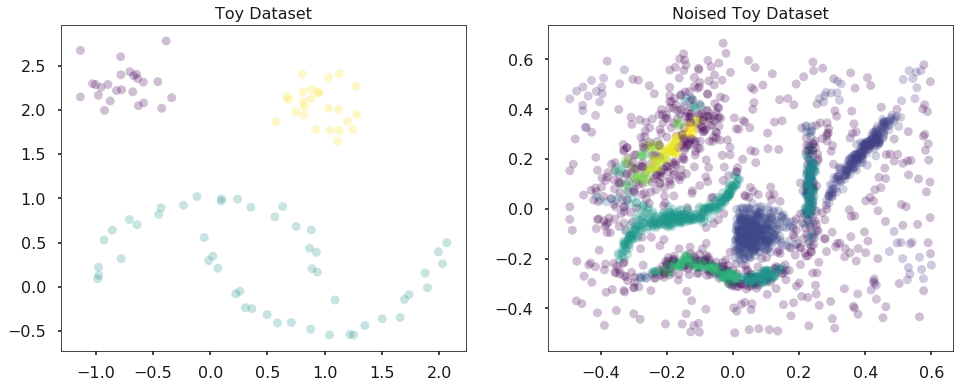

In [19]:
import hdbscan
hdbscan_0 = hdbscan.HDBSCAN().fit(test_data_0)
hdbscan_1 = hdbscan.HDBSCAN().fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=hdbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=hdbscan_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();


## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


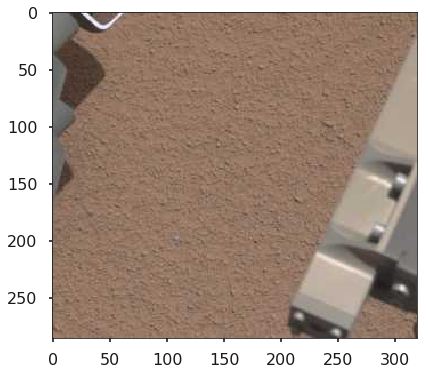

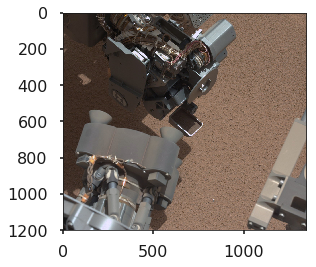

In [20]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')
Im_2 = Image.open('im_nasa.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()
plt.imshow(Im_2)
plt.show()

In [21]:
#Transforming image into array
import matplotlib.image as img
from numpy import array

arr_img = array(Im_1)
print(arr_img.shape)
print(arr_img[:3][:3])

(286, 320, 3)
[[[132 133 128]
  [131 132 127]
  [130 131 126]
  ...
  [144 117  96]
  [142 115  94]
  [140 113  92]]

 [[132 133 128]
  [131 132 127]
  [130 131 126]
  ...
  [150 123 102]
  [144 117  96]
  [139 112  91]]

 [[131 132 127]
  [130 131 126]
  [129 130 125]
  ...
  [151 124 103]
  [142 115  94]
  [134 107  86]]]


In [22]:
#From 3 variables to 2 variables (R,G,B to I,S)
def reduc (X):
    n = X.shape[2]
    row = X.shape[0]
    col = X.shape[1]
    coord = np.zeros((row*col, 2))
    f = np.zeros((row*col, n))
    c=0
    for i in range(row):
        for j in range(col):
            f[c] = X[i][j]
            coord[c,0] = i
            coord[c,1] = j
            c+=1       
    return(f, coord)

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [23]:
X_img1 = np.array([[([0 for k in range(2)]) for j in range(arr_img.shape[1])] for i in range(arr_img.shape[0])])
for i in range(X_img1.shape[0]):
    for j in range (X_img1.shape[1]):
        I = (arr_img[i][j][0] + arr_img[i][j][1] + arr_img[i][j][2])/3
        S = 1 - I*min(arr_img[i][j][0], arr_img[i][j][1], arr_img[i][j][2])
        X_img1[i][j][0] = I
        X_img1[i][j][1] = S


/Users/soufianehadji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.


In [24]:
#Transforming matrix X
X_img1_ = reduc(X_img1)[0]
coord = reduc(X_img1)[1]
print(X_img1_.shape)
print(X_img1_)
print(coord)


(91520, 2)
[[   45. -5844.]
 [   44. -5671.]
 [   43. -5501.]
 ...
 [   22. -2084.]
 [   78. -4835.]
 [   45. -1304.]]
[[  0.   0.]
 [  0.   1.]
 [  0.   2.]
 ...
 [285. 317.]
 [285. 318.]
 [285. 319.]]


In [25]:
model_nasa = hdbscan.HDBSCAN(algorithm = 'boruvka_kdtree')
model_nasa = hdbscan.HDBSCAN().fit(X_img1_)

In [26]:
model_nasa.labels_

array([  -1, 1554, 1549, ...,  939,  166,   -1])

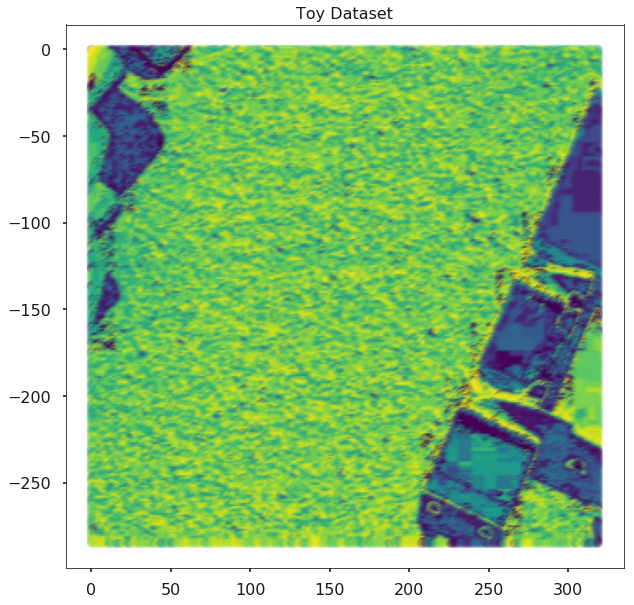

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(coord.T[1], -coord.T[0], c=model_nasa.labels_ , **plot_kwds)
ax.set_title('Toy Dataset', size=16)

plt.show()

- Apply the seen algorithms to segment the image, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

/Users/soufianehadji/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/soufianehadji/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


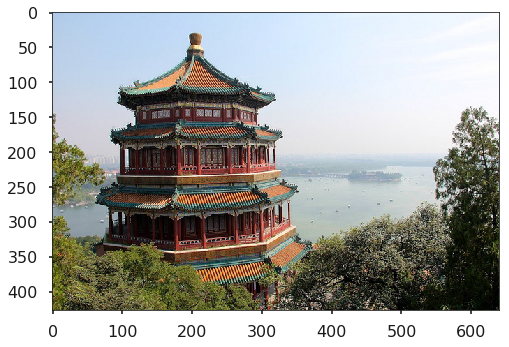

In [28]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

In [29]:
arr_china = array(china)
print(arr_china.shape)
print(arr_china[:3][:3])

(427, 640, 3)
[[[174 201 231]
  [174 201 231]
  [174 201 231]
  ...
  [250 251 255]
  [250 251 255]
  [250 251 255]]

 [[172 199 229]
  [173 200 230]
  [173 200 230]
  ...
  [251 252 255]
  [251 252 255]
  [251 252 255]]

 [[174 201 231]
  [174 201 231]
  [174 201 231]
  ...
  [252 253 255]
  [252 253 255]
  [252 253 255]]]


In [30]:
X_china = reduc(arr_china)[0]  

In [31]:
X_china.shape

(273280, 3)

In [32]:
kmeans_china = KMeans(n_clusters=10, max_iter=200).fit(X_china)

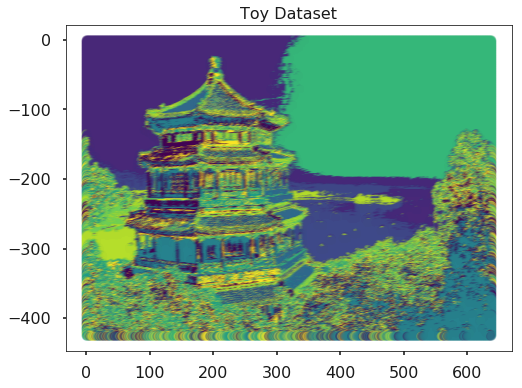

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(reduc(arr_china)[1].T[1], -reduc(arr_china)[1].T[0], c=kmeans_china.labels_ , **plot_kwds)
ax.set_title('Toy Dataset', size=16)

plt.show()